# Assignment 1 - Luise Kutzner, Lara .., Eva Franck

In [8]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import indexable
from sklearn.utils import resample
from sklearn.utils.validation import _num_samples
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from math import ceil, floor

from sklearn.utils import (
    _safe_indexing,
    check_random_state,
    indexable,
    metadata_routing,
)


# Task 1: Setting the Baseline

## Task 1.1 Data Preparation and Validation Pipeline

In [9]:
def transform_to_trajectories_dataframe(X_data, idx):
    """
    Transforms the dataset into a single pandas DataFrame where each sample is labeled
    with a 'trajectory_id' indicating which 258-sample trajectory it belongs to.
    
    Parameters:
    - X_data: pandas DataFrame containing the dataset.
    - idx: list of indices that partition the dataset into 258-sample stacks (trajectories).

    Returns:
    - A pandas DataFrame with an added 'trajectory_id' column.
    """
    
    # Initialize an empty list to store DataFrame chunks with trajectory IDs
    transformed_data = []
    
    # Iterate through the indices list to slice the dataframe into stacks
    for i in range(len(idx) - 1):
        # Each stack corresponds to samples from idx[i] to idx[i + 1]
        start_idx = idx[i]
        end_idx = idx[i + 1]
        
        # Slice the DataFrame to get the trajectory
        trajectory = X_data.iloc[start_idx:end_idx].copy()
        
        # Add a column 'trajectory_id' to label the trajectory
        trajectory['trajectory_id'] = i
        
        # Append to the list of DataFrame chunks
        transformed_data.append(trajectory)
    
    # Concatenate all the chunks into a single DataFrame
    result_df = pd.concat(transformed_data, ignore_index=True)
    
    return result_df


In [10]:
def remove_duplicated_trajectories(X_data, trajectory_col='trajectory_id'):
    """
    Removes trajectories from the dataset that have duplicated first sample points.
    
    Parameters:
    - X_data: pandas DataFrame containing the dataset.
    - trajectory_col: The name of the column that identifies different trajectories.
    
    Returns:
    - A DataFrame with the duplicated first sample point trajectories removed.
    """
    
    # Get the first sample of each trajectory
    first_samples = X_data.groupby(trajectory_col).first().reset_index()
    
    # Find duplicates in the first samples
    duplicated_first_samples = first_samples.duplicated(subset=X_data.columns.difference([trajectory_col]), keep='first')

    true_count = duplicated_first_samples.sum()
    index = duplicated_first_samples[duplicated_first_samples].index
    print(f"Found {true_count} duplicated first samples with indices {index}.")
    
    # Keep only unique first samples
    unique_trajectories = first_samples.loc[~duplicated_first_samples, trajectory_col]
    
    # Filter the original dataframe to keep only unique trajectories
    cleaned_data = X_data[X_data[trajectory_col].isin(unique_trajectories)]

    return cleaned_data


In [11]:
def _validate_shuffle_split(n_samples, test_size, train_size, default_test_size=None):
    """
    Validation helper to check if the test/test sizes are meaningful w.r.t. the
    size of the data (n_samples).
    """
    if test_size is None and train_size is None:
        test_size = default_test_size

    test_size_type = np.asarray(test_size).dtype.kind
    train_size_type = np.asarray(train_size).dtype.kind

    if (
        test_size_type == "i"
        and (test_size >= n_samples or test_size <= 0)
        or test_size_type == "f"
        and (test_size <= 0 or test_size >= 1)
    ):
        raise ValueError(
            "test_size={0} should be either positive and smaller"
            " than the number of samples {1} or a float in the "
            "(0, 1) range".format(test_size, n_samples)
        )

    if (
        train_size_type == "i"
        and (train_size >= n_samples or train_size <= 0)
        or train_size_type == "f"
        and (train_size <= 0 or train_size >= 1)
    ):
        raise ValueError(
            "train_size={0} should be either positive and smaller"
            " than the number of samples {1} or a float in the "
            "(0, 1) range".format(train_size, n_samples)
        )

    if train_size is not None and train_size_type not in ("i", "f"):
        raise ValueError("Invalid value for train_size: {}".format(train_size))
    if test_size is not None and test_size_type not in ("i", "f"):
        raise ValueError("Invalid value for test_size: {}".format(test_size))

    if train_size_type == "f" and test_size_type == "f" and train_size + test_size > 1:
        raise ValueError(
            "The sum of test_size and train_size = {}, should be in the (0, 1)"
            " range. Reduce test_size and/or train_size.".format(train_size + test_size)
        )

    if test_size_type == "f":
        n_test = ceil(test_size * n_samples)
    elif test_size_type == "i":
        n_test = float(test_size)

    if train_size_type == "f":
        n_train = floor(train_size * n_samples)
    elif train_size_type == "i":
        n_train = float(train_size)

    if train_size is None:
        n_train = n_samples - n_test
    elif test_size is None:
        n_test = n_samples - n_train

    if n_train + n_test > n_samples:
        raise ValueError(
            "The sum of train_size and test_size = %d, "
            "should be smaller than the number of "
            "samples %d. Reduce test_size and/or "
            "train_size." % (n_train + n_test, n_samples)
        )

    n_train, n_test = int(n_train), int(n_test)

    if n_train == 0:
        raise ValueError(
            "With n_samples={}, test_size={} and train_size={}, the "
            "resulting train set will be empty. Adjust any of the "
            "aforementioned parameters.".format(n_samples, test_size, train_size)
        )

    return n_train, n_test

In [12]:
# Redefine test split function based on trajectories

def train_test_split_traj(
    *arrays,
    test_size=None,
    train_size=None,
    random_state=None,
    shuffle=True,
    stratify=None,
    trajectory_col='trajectory_id',  # Column indicating trajectory
):
    """
    Splits the dataset based on trajectories identified by `trajectory_id` into training, validation, and test sets.
    
    Parameters:
    - *arrays: The data arrays to split (e.g., features, labels).
    - test_size: Proportion of the data to allocate for the test set.
    - train_size: Proportion of the data to allocate for the train set.
    - random_state: Random seed for reproducibility.
    - shuffle: Whether to shuffle the data before splitting.
    - stratify: Array for stratification during splitting (optional).
    - trajectory_col: The name of the column that identifies different trajectories.
    
    Returns:
    - Split arrays based on the trajectory groups (train, test, etc.).
    """
    # Ensure at least one array is provided
    n_arrays = len(arrays)
    if n_arrays == 0:
        raise ValueError("At least one array required as input")

    arrays = indexable(*arrays)

    # First array should be the dataframe with trajectory column
    if isinstance(arrays[0], pd.DataFrame) and trajectory_col in arrays[0].columns:
        X_data = arrays[0]
        # Get unique trajectory IDs
        unique_trajectories = X_data[trajectory_col].unique()
    else:
        raise ValueError(f"The first array must be a DataFrame containing the column '{trajectory_col}'.")

    # Number of unique trajectories
    n_trajectories = len(unique_trajectories)
    
    # Determine number of trajectories for training and testing
    n_train, n_test = _validate_shuffle_split(
        n_trajectories, test_size, train_size, default_test_size=0.25
    )

    # Shuffle trajectories if needed
    if shuffle:
        np.random.seed(random_state)
        np.random.shuffle(unique_trajectories)

    if stratify is not None:
        raise ValueError("Stratified train/test split is not implemented for trajectories")

    # Split trajectories into training and test sets
    train_trajectories = unique_trajectories[:n_train]
    test_trajectories = unique_trajectories[n_train:n_train + n_test]

    # Create masks for train and test trajectories
    train_mask = X_data[trajectory_col].isin(train_trajectories)
    test_mask = X_data[trajectory_col].isin(test_trajectories)

    # Split each array according to the masks
    split_arrays = []
    for array in arrays:
        if isinstance(array, pd.DataFrame):
            train_array = array[train_mask]
            test_array = array[test_mask]
        else:
            # For non-DataFrame arrays, assume same length and split accordingly
            train_array = array[train_mask.to_numpy()]
            test_array = array[test_mask.to_numpy()]

        split_arrays.extend([train_array, test_array])

    return split_arrays


In [13]:
def train_validate_test_split(
    *arrays,
    test_size=None,
    validate_size=None,  # New parameter for validation set size
    train_size=None,
    random_state=None,
    shuffle=True,
    trajectory_col='trajectory_id',  # Column indicating trajectory
):
    """
    Splits the dataset based on trajectories identified by `trajectory_id` into training, validation, and test sets.
    
    Parameters:
    - *arrays: The data arrays to split (e.g., features, labels).
    - test_size: Proportion of the data to allocate for the test set.
    - validate_size: Proportion of the data to allocate for the validation set.
    - train_size: Proportion of the data to allocate for the train set.
    - random_state: Random seed for reproducibility.
    - shuffle: Whether to shuffle the data before splitting.
    - trajectory_col: The name of the column that identifies different trajectories.
    
    Returns:
    - Split arrays (train, validation, test) based on the trajectory groups.
    """
    # Ensure at least one array is provided
    n_arrays = len(arrays)
    if n_arrays == 0:
        raise ValueError("At least one array required as input")

    arrays = indexable(*arrays)

    # First array should be the dataframe with trajectory column
    if isinstance(arrays[0], pd.DataFrame) and trajectory_col in arrays[0].columns:
        X_data = arrays[0]
        # Get unique trajectory IDs
        unique_trajectories = X_data[trajectory_col].unique()
    else:
        raise ValueError(f"The first array must be a DataFrame containing the column '{trajectory_col}'.")

    # Number of unique trajectories
    n_trajectories = len(unique_trajectories)

    # Split the data into training and (validation + test)
    n_train, n_temp = _validate_shuffle_split(
        n_trajectories, test_size + validate_size, train_size, default_test_size=0.25
    )

    # Shuffle trajectories if needed
    if shuffle:
        np.random.seed(random_state)
        np.random.shuffle(unique_trajectories)

    # Split into train and temporary sets
    train_trajectories = unique_trajectories[:n_train]
    temp_trajectories = unique_trajectories[n_train:n_train + n_temp]

    # Further split temporary set into validation and test sets
    n_validate = int(validate_size * n_trajectories)
    validate_trajectories = temp_trajectories[:n_validate]
    test_trajectories = temp_trajectories[n_validate:]

    # Create masks for train, validation, and test trajectories
    train_mask = X_data[trajectory_col].isin(train_trajectories)
    validate_mask = X_data[trajectory_col].isin(validate_trajectories)
    test_mask = X_data[trajectory_col].isin(test_trajectories)

    # Split each array according to the masks
    split_arrays = []
    for array in arrays:
        if isinstance(array, pd.DataFrame):
            train_array = array[train_mask]
            validate_array = array[validate_mask]
            test_array = array[test_mask]
        else:
            # For non-DataFrame arrays, assume same length and split accordingly
            train_array = array[train_mask.to_numpy()]
            validate_array = array[validate_mask.to_numpy()]
            test_array = array[test_mask.to_numpy()]

        split_arrays.extend([train_array, validate_array, test_array])

    return split_arrays


In [14]:
data = pd.read_csv('../mlNOVA/mlNOVA/X_train.csv')
data2 = pd.read_csv('../mlNOVA/mlNOVA/X_test.csv')

In [15]:
data.head()

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
0,0.000000,1.000000,0.000000,0.000000,0.000000,-0.266467,0.859196,0.000000,0.000000,-0.733533,-0.859196,0.000000,0.000000,0
1,0.039062,0.999548,0.000092,-0.023159,0.004731,-0.266261,0.858781,0.010574,-0.021257,-0.733287,-0.858874,0.012584,0.016526,1
2,0.078125,0.998190,0.000370,-0.046362,0.009474,-0.265641,0.857535,0.021172,-0.042552,-0.732549,-0.857905,0.025189,0.033078,2
3,0.117188,0.995925,0.000833,-0.069654,0.014239,-0.264606,0.855456,0.031817,-0.063924,-0.731318,-0.856289,0.037837,0.049685,3
4,0.156250,0.992747,0.001483,-0.093080,0.019040,-0.263154,0.852540,0.042533,-0.085412,-0.729592,-0.854022,0.050548,0.066372,4


In [16]:
data2.head()

,Id,t,x0_1,y0_1,x0_2,y0_2,x0_3,y0_3
0,0,0.000000,1.0,0.0,-0.179617,0.730085,-0.820383,-0.730085
1,1,0.039062,1.0,0.0,-0.179617,0.730085,-0.820383,-0.730085
2,2,0.078125,1.0,0.0,-0.179617,0.730085,-0.820383,-0.730085
3,3,0.117188,1.0,0.0,-0.179617,0.730085,-0.820383,-0.730085
4,4,0.156250,1.0,0.0,-0.179617,0.730085,-0.820383,-0.730085


In [17]:
data.columns

Index(['t', 'x_1', 'y_1', 'v_x_1', 'v_y_1', 'x_2', 'y_2', 'v_x_2', 'v_y_2',
       'x_3', 'y_3', 'v_x_3', 'v_y_3', 'Id'],
      dtype='object')

In [18]:
idx = np.hstack((0, data[data.t == 10].index.values + 1))[:-1]

665


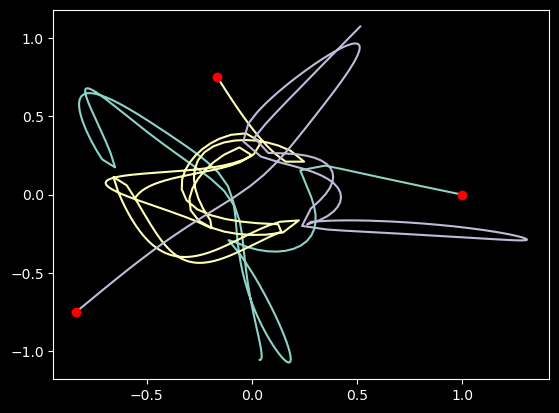

In [19]:
k = np.random.randint(idx.shape[0])
print(k)
pltidx = range(idx[k], 257 + idx[k])
pltsquare = idx[k]

plt.plot(data.x_1[pltidx], data.y_1[pltidx])
plt.plot(data.x_2[pltidx], data.y_2[pltidx])
plt.plot(data.x_3[pltidx], data.y_3[pltidx])

plt.plot(data.x_1[pltsquare], data.y_1[pltsquare], 'ro')
plt.plot(data.x_2[pltsquare], data.y_2[pltsquare], 'ro')
plt.plot(data.x_3[pltsquare], data.y_3[pltsquare], 'ro')

In [20]:
data.head()

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
0,0.000000,1.000000,0.000000,0.000000,0.000000,-0.266467,0.859196,0.000000,0.000000,-0.733533,-0.859196,0.000000,0.000000,0
1,0.039062,0.999548,0.000092,-0.023159,0.004731,-0.266261,0.858781,0.010574,-0.021257,-0.733287,-0.858874,0.012584,0.016526,1
2,0.078125,0.998190,0.000370,-0.046362,0.009474,-0.265641,0.857535,0.021172,-0.042552,-0.732549,-0.857905,0.025189,0.033078,2
3,0.117188,0.995925,0.000833,-0.069654,0.014239,-0.264606,0.855456,0.031817,-0.063924,-0.731318,-0.856289,0.037837,0.049685,3
4,0.156250,0.992747,0.001483,-0.093080,0.019040,-0.263154,0.852540,0.042533,-0.085412,-0.729592,-0.854022,0.050548,0.066372,4


In [21]:
data_cleaned = data.drop(columns=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3', 'Id'])

In [22]:
# Extract the X data and bring it into a form such that you have the initial conditions 
# along with the time t at which y describes the current x and y positions

X_data = data_cleaned.copy()
for i in idx:
    # Select the first sample's column values in the current stack
    x_1_value = data_cleaned.loc[i, 'x_1']
    y_1_value = data_cleaned.loc[i, 'y_1']
    x_2_value = data_cleaned.loc[i, 'x_2']
    y_2_value = data_cleaned.loc[i, 'y_2']
    x_3_value = data_cleaned.loc[i, 'x_3']
    y_3_value = data_cleaned.loc[i, 'y_3']
    
    # Update the column values for all 258 samples in this stack
    X_data.loc[i:i+257, 'x_1'] = x_1_value
    X_data.loc[i:i+257, 'y_1'] = y_1_value
    X_data.loc[i:i+257, 'x_2'] = x_2_value
    X_data.loc[i:i+257, 'y_2'] = y_2_value
    X_data.loc[i:i+257, 'x_3'] = x_3_value
    X_data.loc[i:i+257, 'y_3'] = y_3_value


In [23]:
y_data = data_cleaned.copy()
y_data.head()

,t,x_1,y_1,x_2,y_2,x_3,y_3
0,0.000000,1.000000,0.000000,-0.266467,0.859196,-0.733533,-0.859196
1,0.039062,0.999548,0.000092,-0.266261,0.858781,-0.733287,-0.858874
2,0.078125,0.998190,0.000370,-0.265641,0.857535,-0.732549,-0.857905
3,0.117188,0.995925,0.000833,-0.264606,0.855456,-0.731318,-0.856289
4,0.156250,0.992747,0.001483,-0.263154,0.852540,-0.729592,-0.854022


In [24]:
# add a trajectory_id flag such that the data can be split into trajectories

X_data_traj = transform_to_trajectories_dataframe(X_data, idx)
y_data_traj = transform_to_trajectories_dataframe(y_data, idx)


In [25]:
# remove trajectories with duplicated initial positions

cleaned_X_data = remove_duplicated_trajectories(X_data_traj, trajectory_col='trajectory_id')
cleaned_y_data = remove_duplicated_trajectories(y_data_traj, trajectory_col='trajectory_id')

Found 1 duplicated first samples with indices Index([3297], dtype='int64').
Found 1 duplicated first samples with indices Index([3297], dtype='int64').


In [26]:
# columns_to_compare = ['t', 'x_1', 'x_2', 'x_3', 'y_1', 'y_2', 'y_3']
# matching_samples = X_data_traj[(X_data_traj[columns_to_compare] ==  X_data_traj.iloc[1042906][columns_to_compare].values).all(axis=1)]
# matching_samples[matching_samples.index.isin(idx)]

In [27]:
# split data into training, validation and test sets

X_train_2, X_val_2, X_test_2, y_train_2, y_val_2, y_test_2 = train_validate_test_split(cleaned_X_data, cleaned_y_data, validate_size= 0.1, test_size=0.1)

In [28]:
# Remove the trajectory_id column

# X_train_2 = X_train_2.drop(columns=['trajectory_id'])
# X_val_2 = X_val_2.drop(columns=['trajectory_id'])
# X_test_2 = X_test_2.drop(columns=['trajectory_id'])
# y_train_2 = y_train_2.drop(columns=['trajectory_id'])
# y_val_2 = y_val_2.drop(columns=['trajectory_id'])
# y_test_2 = y_test_2.drop(columns=['trajectory_id'])

In [29]:
# # Remove the trajectory_id column for all sets and t for the y_datasets
# otherwise (the prediction will overfit) the RSME will be much different from kaggle

X_train_2 = X_train_2.drop(columns=['trajectory_id'])
X_val_2 = X_val_2.drop(columns=['trajectory_id'])
X_test_2 = X_test_2.drop(columns=['trajectory_id'])
y_train_2 = y_train_2.drop(columns=['trajectory_id', 't'])
y_val_2 = y_val_2.drop(columns=['trajectory_id', 't'])
y_test_2 = y_test_2.drop(columns=['trajectory_id', 't'])

In [30]:
y_train_2.head()

,x_1,y_1,x_2,y_2,x_3,y_3
0,1.000000,0.000000,-0.266467,0.859196,-0.733533,-0.859196
1,0.999548,0.000092,-0.266261,0.858781,-0.733287,-0.858874
2,0.998190,0.000370,-0.265641,0.857535,-0.732549,-0.857905
3,0.995925,0.000833,-0.264606,0.855456,-0.731318,-0.856289
4,0.992747,0.001483,-0.263154,0.852540,-0.729592,-0.854022


## 1.2 Learn the baseline model

In [31]:
# Create pipeline
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()), 
    ('regressor', LinearRegression())  
])

#pipeline = LinearRegression()

pipeline.fit(X_train_2, y_train_2)
pipeline['regressor'].score(X_train_2, y_train_2)
#pipeline['regressor'].coef_
#pipeline['regressor'].intercept_

c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


-3980671175070558.5

In [32]:
y_val_pred_2 = pipeline.predict(X_val_2)

In [33]:
# make a dataframe out of y_val_pred_2
y_val_pred_2_df = pd.DataFrame(y_val_pred_2, columns=y_val_2.columns)
y_val_pred_2_df

,x_1,y_1,x_2,y_2,x_3,y_3
0,0.524846,0.017238,-0.129703,0.114107,-0.395143,-0.131345
1,0.519749,0.016709,-0.129221,0.111664,-0.390527,-0.128373
2,0.514651,0.016181,-0.128739,0.109221,-0.385912,-0.125401
3,0.509553,0.015652,-0.128257,0.106777,-0.381296,-0.122429
4,0.504456,0.015124,-0.127775,0.104334,-0.376681,-0.119457
...,...,...,...,...,...,...
127467,-0.956713,-0.208648,0.074120,-0.300153,0.882592,0.508802
127468,-0.961810,-0.209177,0.074603,-0.302597,0.887207,0.511774
127469,-0.966909,-0.209706,0.075085,-0.305041,0.891824,0.514746
127470,-0.972006,-0.210234,0.075567,-0.307484,0.896439,0.517718


In [34]:
rmse = np.sqrt(mean_squared_error(y_val_2, y_val_pred_2))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 1.3706340196755593


In [35]:
def plot_y_yhat(y_val,y_pred, plot_title = "plot"):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    if len(y_val) > MAX:
        idx = np.random.choice(len(y_val),MAX, replace=False)
    else:
        idx = np.arange(len(y_val))
    
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_val[idx,i])
        x1 = np.max(y_val[idx,i])
        plt.subplot(3, 2, i+1)
        plt.scatter(y_val[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    #plt.savefig(plot_title+'.pdf')
    plt.show()

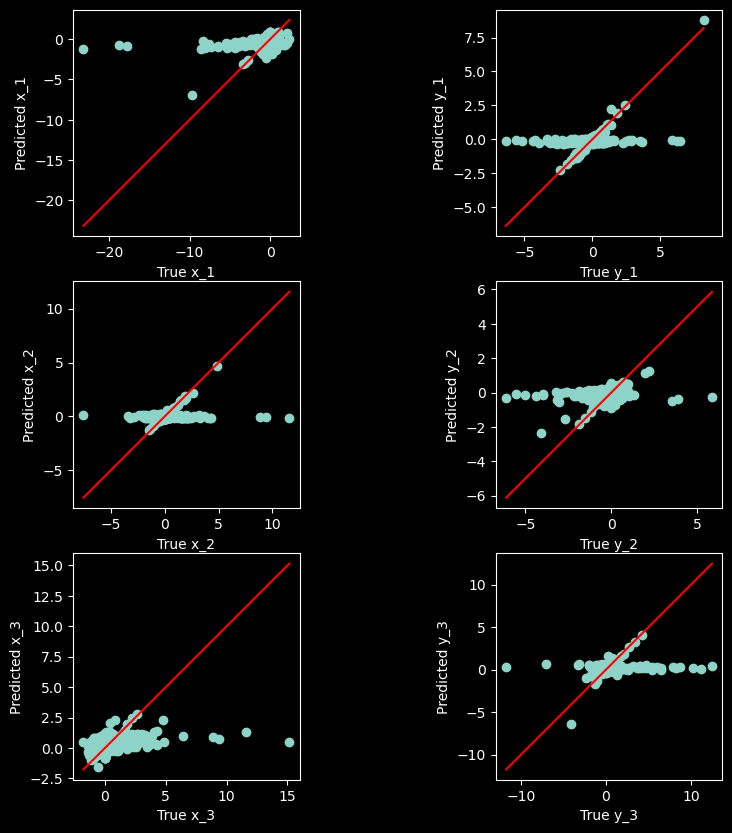

In [36]:
# make a numpy array out of y_val_2
y_val_2_np = y_val_2.to_numpy()
plot_y_yhat(y_val_2_np,y_val_pred_2)

In [37]:
data2['x_1'] = data2['x0_1']
data2['y_1'] = data2['y0_1']
data2['x_2'] = data2['x0_2']
data2['y_2'] = data2['y0_2']
data2['x_3'] = data2['x0_3']
data2['y_3'] = data2['y0_3']
data2 = data2.drop(columns=['Id', 'x0_1', 'y0_1', 'x0_2', 'y0_2', 'x0_3', 'y0_3'])
y_data2 = pipeline.predict(data2)

In [38]:
y_data2 = pd.DataFrame(y_data2, columns=y_val_2.columns)
y_data2['id'] = y_data2.index
columns_titles = ["id","x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]
y_data2=y_data2.reindex(columns=columns_titles)
y_data2.to_csv('sample_submission.csv',index=False)

# Task 2: Nonlinear models on the data - the Polynomial Regression Model

## Task 2.1 Development

In [39]:
# Create pipeline
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()), 
    ('regressor', LinearRegression())  
])

#pipeline = LinearRegression()

pipeline.fit(X_train_2, y_train_2)
pipeline['regressor'].score(X_train_2, y_train_2)
#pipeline['regressor'].coef_
#pipeline['regressor'].intercept_

c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


-3980671175070558.5

In [40]:
X_train, X_val, X_test, y_train, y_val, y_test = train_validate_test_split(cleaned_X_data, cleaned_y_data, validate_size= 0.1, test_size=0.1)

In [41]:
def sample_trajectories(X, y, trajectory_col='trajectory_id', sample_fraction=0.01, random_state=42):

    unique_trajectories = X[trajectory_col].unique()
  
    sampled_trajectories = resample(unique_trajectories, n_samples=int(sample_fraction * len(unique_trajectories)), random_state=random_state)
    
    X_sampled = X[X[trajectory_col].isin(sampled_trajectories)]
    y_sampled = y[X[trajectory_col].isin(sampled_trajectories)]
    
    return X_sampled, y_sampled

X_train_sampled, y_train_sampled = sample_trajectories(X_train, y_train, sample_fraction=0.01)
X_val_sampled, y_val_sampled = sample_trajectories(X_val, y_val, sample_fraction=0.01)
X_test_sampled, y_test_sampled = sample_trajectories(X_test, y_test, sample_fraction=0.01)

In [42]:
X_train_sampled = X_train_sampled.drop(columns=['trajectory_id'])
X_val_sampled = X_val_sampled.drop(columns=['trajectory_id'])
X_test_sampled = X_test_sampled.drop(columns=['trajectory_id'])
y_train_sampled = y_train_sampled.drop(columns=['trajectory_id', 't'])
y_val_sampled = y_val_sampled.drop(columns=['trajectory_id', 't'])
y_test_sampled = y_test_sampled.drop(columns=['trajectory_id', 't'])

In [43]:
def validate_poly_regression(X_train, y_train, X_val, y_val, regressor=None, degrees=range(1,15), max_features=None):
    """
    Perform polynomial regression with different polynomial degrees and plot the results.
    
    Parameters:
    - X_train: Training features.
    - y_train: Training labels.
    - X_val: Validation features.
    - y_val: Validation labels.
    - degrees: List of polynomial degrees to test.
    - max_features: Maximum number of features to use in the regression.
    
    Returns:
    - The polynomial degree that gives the best validation performance.
    """
    
    if regressor is None:
        regressor = RidgeCV(alphas=np.logspace(-6, 6, 13), store_cv_values=True)
    
    best_rmse = float('inf')
    rmse_dict = {}
    best_pipeline = None
    
    # Iterate through the polynomial degrees
    for degree in degrees:
        # Create a pipeline for polynomial regression
        pipeline = Pipeline(steps=[
                ('poly', PolynomialFeatures(degree=degree)),
                ('scaler', StandardScaler()),
                ('regressor', regressor)
            ])
        
        # Fit the pipeline
        pipeline.fit(X_train, y_train)
        
        # print number of features for each degree 
        poly_features = pipeline.named_steps['poly']
        print(f'Degree: {degree}, Number of Features: {poly_features.n_output_features_}')
        
        if max_features is not None and poly_features.n_output_features_ > max_features:
            print(f"Skipping degree {degree} as it exceeds max_features={max_features}.")
            continue
        
        # Predict the labels
        y_val_pred = pipeline.predict(X_val)
        
        num_features = pipeline.named_steps['poly'].n_output_features_
        
        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        print(f'Degree: {degree}, RMSE: {rmse}')
        
        rmse_dict[(degree, num_features)] = rmse
        
        # Update the best degree if the current model is better
        if rmse < best_rmse:
            best_rmse = rmse
            best_pipeline = pipeline
        
        if max_features and num_features > max_features:
            break
        
    return rmse_dict, best_rmse, best_pipeline
    
    

In [45]:
rmse_dict, best_rmse, best_pipeline = validate_poly_regression(X_train_sampled, y_train_sampled, X_val_sampled, y_val_sampled, regressor=None, degrees=range(1,7), max_features=None)

Degree: 1, Number of Features: 8
Degree: 1, RMSE: 0.7650406302490992
Degree: 2, Number of Features: 36
Degree: 2, RMSE: 0.9618271735034539
Degree: 3, Number of Features: 120
Degree: 3, RMSE: 1.3137252286097458
Degree: 4, Number of Features: 330
Degree: 4, RMSE: 1.5304094061466407
Degree: 5, Number of Features: 792
Degree: 5, RMSE: 1.7037615501137084
Degree: 6, Number of Features: 1716
Degree: 6, RMSE: 1.8530843414509608


In [ ]:
    # Plot the MSE values
    plt.figure(figsize=(10, 5))
    plt.plot(degrees, mse_values, marker='o')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('Mean Squared Error')
    plt.title('Validation Performance vs. Polynomial Degree')
    plt.grid(True)
    plt.xticks(degrees)
    plt.show()